In [1]:
import sys, re, itertools, pandas as pd
import matplotlib.pyplot as plt

def read_text(path):
    if path == "-" or path is None:
        return sys.stdin.read()
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

CMD_GPU = re.compile(r'\./vecaddgpu(00|01)\s+(\d+)\s+(\d+)')
CMD_CPU = re.compile(r'\./vecaddcpu\s+(\d+)')
RX_EXEC = re.compile(r'Execution Time\s*:\s*([0-9.]+)\s*millisec', re.I)
RX_TOT  = re.compile(r'Total Time\s*:\s*([0-9.]+)\s*millisec', re.I)
RX_ANYMS= re.compile(r'([0-9.]+)\s*(?:ms|millisec)\b', re.I)

def parse(text):
    rows = []
    cur = None
    for line in text.splitlines():
        m = CMD_GPU.search(line)
        if m:
            prog = 'no_um' if m.group(1) == '00' else 'um'
            K = int(m.group(2)); scen = int(m.group(3))
            cur = {'prog': prog, 'K': K, 'scenario': scen, 'exec_ms': None, 'total_ms': None}
            rows.append(cur); continue
        m = CMD_CPU.search(line)
        if m:
            K = int(m.group(1))
            cur = {'prog': 'cpu', 'K': K, 'scenario': 0, 'exec_ms': None, 'total_ms': None}
            rows.append(cur); continue
        if cur is not None:
            me = RX_EXEC.search(line)
            if me: cur['exec_ms'] = float(me.group(1)); continue
            mt = RX_TOT.search(line)
            if mt: cur['total_ms'] = float(mt.group(1)); continue
            # if CPU prints something like "time = X ms"
            if cur['prog']=='cpu' and cur['exec_ms'] is None:
                ma = RX_ANYMS.search(line)
                if ma: cur['exec_ms'] = float(ma.group(1))
    return rows

def df_gpu(rows, prog, metric):
    rows = [r for r in rows if r['prog']==prog]
    rows.sort(key=lambda x:(x['K'], x['scenario']))
    data = {}
    for K, group in itertools.groupby(rows, key=lambda x:x['K']):
        g = list(group)
        s = {r['scenario']: r[metric] for r in g}
        data[K] = {'Scenario1_ms': s.get(1), 'Scenario2_ms': s.get(2), 'Scenario3_ms': s.get(3)}
    df = pd.DataFrame.from_dict(data, orient='index').sort_index().reset_index().rename(columns={'index':'K_millions'})
    return df

def df_cpu(rows, metric):
    rows = [r for r in rows if r['prog']=='cpu']
    data = {r['K']: r[metric] for r in rows if r[metric] is not None}
    if not data: return None
    df = pd.DataFrame({'K_millions': sorted(data.keys()), 'CPU_ms': [data[k] for k in sorted(data.keys())]})
    return df

def attach_cpu(df, cpu_df):
    df = df.copy()
    df.insert(1, 'CPU_ms', [None]*len(df))
    if cpu_df is not None:
        m = pd.merge(df[['K_millions']], cpu_df, how='left', on='K_millions')
        df['CPU_ms'] = m['CPU_ms']
    return df

def make_chart(df, title, out_png, ylab, logy=True):
    plt.figure()
    x = df['K_millions']
    if df['CPU_ms'].notna().any():
        plt.plot(x, df['CPU_ms'], marker='o', label='CPU')
    plt.plot(x, df['Scenario1_ms'], marker='o', label='GPU scenario 1')
    plt.plot(x, df['Scenario2_ms'], marker='o', label='GPU scenario 2')
    plt.plot(x, df['Scenario3_ms'], marker='o', label='GPU scenario 3')
    plt.xlabel('K (millions)')
    plt.ylabel(ylab)
    plt.title(title)
    if logy: plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(); plt.tight_layout(); plt.savefig(out_png, dpi=180)


Wrote CSVs and PNGs.


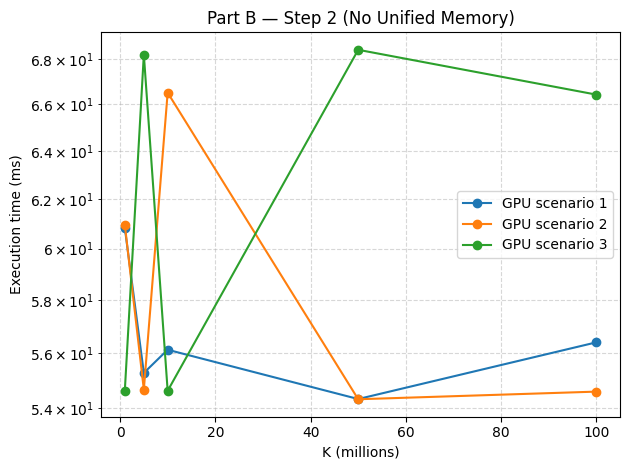

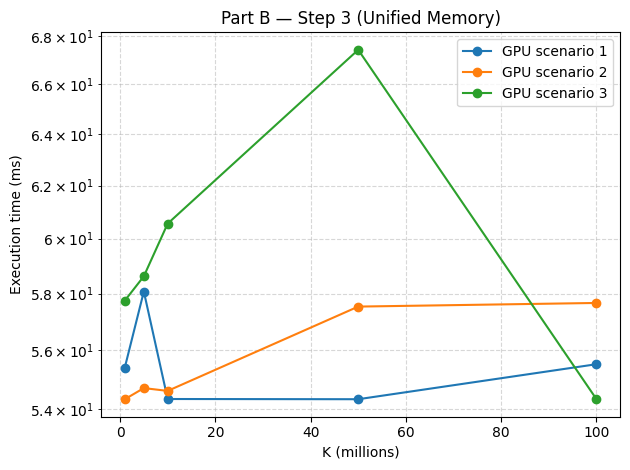

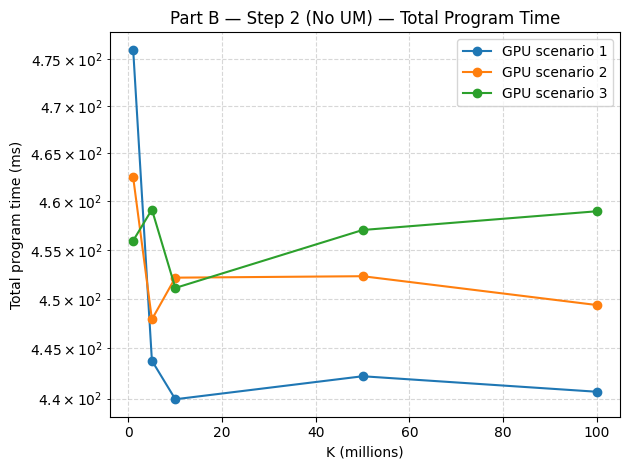

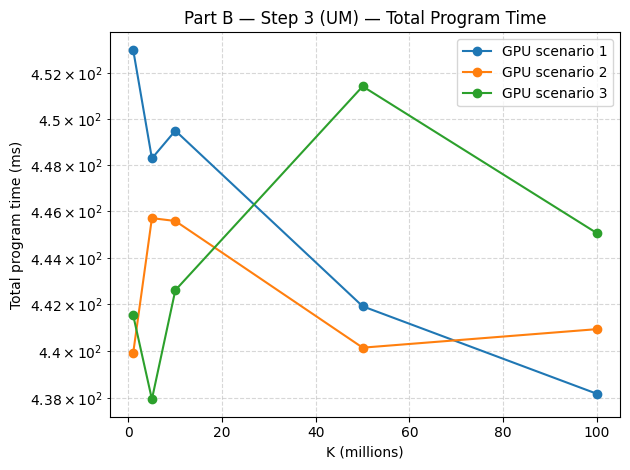

In [2]:
path = '/content/logs.txt'
text = read_text(path)
rows = parse(text)
dfe2 = df_gpu(rows, 'no_um', 'exec_ms')
dfe3 = df_gpu(rows, 'um',    'exec_ms')
dft2 = df_gpu(rows, 'no_um', 'total_ms')
dft3 = df_gpu(rows, 'um',    'total_ms')
dfc_exec = df_cpu(rows, 'exec_ms')

dfe2 = attach_cpu(dfe2, dfc_exec)
dfe3 = attach_cpu(dfe3, dfc_exec)
dft2 = attach_cpu(dft2, dfc_exec)
dft3 = attach_cpu(dft3, dfc_exec)

dfe2.to_csv('partB_results_step2_exec.csv', index=False)
dfe3.to_csv('partB_results_step3_exec.csv', index=False)
dft2.to_csv('partB_results_step2_total.csv', index=False)
dft3.to_csv('partB_results_step3_total.csv', index=False)

make_chart(dfe2, 'Part B — Step 2 (No Unified Memory)', 'partB_step2_exec.png', 'Execution time (ms)', logy=True)
make_chart(dfe3, 'Part B — Step 3 (Unified Memory)',    'partB_step3_exec.png', 'Execution time (ms)', logy=True)
make_chart(dft2, 'Part B — Step 2 (No UM) — Total Program Time', 'partB_step2_total.png', 'Total program time (ms)', logy=True)
make_chart(dft3, 'Part B — Step 3 (UM) — Total Program Time',    'partB_step3_total.png', 'Total program time (ms)', logy=True)
print("Wrote CSVs and PNGs.")